In order to asses how well individual network weights correspond to functional similarity, we'll look at three different similarity metrics based solely on Gene Ontology co-annotation.

First, we define $A(i)$ to be the set of gene ontology annotations given to gene i

1. Jaccard Index - this is: $\frac{|A(i) \cap A(j)|}{|A(i) \cup A(j)|}$
2. Overlap Coefficient - this is: $\frac{|A(i) \cap A(j)|}{min(|A(i)|,|A(j)|)}$
3. Semantic Density (See Singh for citation) - For this, for an annotation $a$ we define $s(a)$ to be the negative log (base 10) of the fraction of genes in the network annotated to $a$. Then  our formula is:
$$\frac{2\bullet max_{a \in A(i) \cap A(j)}{s(a)}}{max_{a \in A(i)}{s(a)} + max_{a \in A(j)}{s(a)}}$$

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../')
from lib.Dab import Dab, get_linear_weights
from lib.Gmt import read_gmt

import matplotlib.pyplot as plt

import scipy.stats

In [2]:
from lib.clustering import *

In [3]:
%%time
d = Dab('../data/global.dab')

CPU times: user 5.04 s, sys: 2.64 s, total: 7.67 s
Wall time: 18.4 s


In [4]:
bp_terms = read_gmt('../gene_ontology/gobp_human.closed.gmt')
cc_terms = read_gmt('../gene_ontology/gocc_human.closed.gmt')

### Jaccard Index

In [5]:
def generate_jaccard(go_terms):
    genes = set()
    for gene_list in go_terms.itervalues():
        genes |= set(gene_list)
    genes = list(genes)
    n = len(genes)
    gene_to_idx = {g: i for i, g in enumerate(genes)}
    terms = go_terms.keys()
    
    # Calculate the intersection size between genes
    gene_to_term_matrix = np.zeros((len(genes), len(terms)), dtype=np.float64)
    for i, t in enumerate(terms):
        for g in go_terms[t]:
            gene_to_term_matrix[gene_to_idx[g], i] = 1.0
    intersection_size = np.dot(gene_to_term_matrix, gene_to_term_matrix.T)
    
    # Calculate the total number of annotations per gene
    annotation_count = np.zeros(n, dtype=np.float64)
    for t in terms:
        gene_idxs = [gene_to_idx[g] for g in go_terms[t]]
        annotation_count[gene_idxs] += 1
    
    # The union size is just the sum the individual annotation counts 
    # minus the size of the intersection
    union_size = np.add(annotation_count.reshape((n, 1)),
                        annotation_count.reshape((1, n))) - intersection_size
    
    ret = Dab()
    ret.genes = genes
    ret.weights = intersection_size/union_size
    return ret

In [6]:
%%time
jaccard_bp = generate_jaccard(bp_terms)

CPU times: user 4min 3s, sys: 7.38 s, total: 4min 11s
Wall time: 37.6 s


In [7]:
%%time
jaccard_cc = generate_jaccard(cc_terms)

CPU times: user 44.3 s, sys: 4.08 s, total: 48.4 s
Wall time: 13.5 s


### Overlap Coefficient

In [8]:
def generate_overlap(go_terms):
    genes = set()
    for gene_list in go_terms.itervalues():
        genes |= set(gene_list)
    genes = list(genes)
    n = len(genes)
    gene_to_idx = {g: i for i, g in enumerate(genes)}
    terms = go_terms.keys()
    
    # Calculate the intersection size between genes
    # Calculate the intersection size between genes
    gene_to_term_matrix = np.zeros((len(genes), len(terms)), dtype=np.float64)
    for i, t in enumerate(terms):
        for g in go_terms[t]:
            gene_to_term_matrix[gene_to_idx[g], i] = 1.0
    intersection_size = np.dot(gene_to_term_matrix, gene_to_term_matrix.T)
    
    annotation_count = np.zeros(n, dtype=np.float64)
    for t in terms:
        gene_idxs = [gene_to_idx[g] for g in go_terms[t]]
        annotation_count[gene_idxs] += 1
    
    # Just take the minimum size between two genes
    min_size = np.minimum(annotation_count.reshape((n, 1)),
                          annotation_count.reshape((1, n)))
    
    ret = Dab()
    ret.genes = genes
    ret.weights = intersection_size/min_size
    return ret

In [9]:
%%time
overlap_bp = generate_overlap(bp_terms)

CPU times: user 4min 3s, sys: 6.63 s, total: 4min 9s
Wall time: 37.1 s


In [10]:
%%time
overlap_cc = generate_overlap(cc_terms)

CPU times: user 44.5 s, sys: 3.5 s, total: 48 s
Wall time: 13 s


In [5]:
def genes_to_annotations(go_terms):
    genes = set()
    for gene_list in go_terms.itervalues():
        genes |= set(gene_list)
    gene_to_annotation = {g:[] for g in genes}
    for term, gene_list in go_terms.iteritems():
        for g in gene_list:
            gene_to_annotation[g].append(term)
    return gene_to_annotation

In [6]:
bp_annotations = genes_to_annotations(bp_terms)
cc_annotations = genes_to_annotations(cc_terms)

In [15]:
def check_jaccard(a, b):
    return (1.0* len(set(a) & set(b)))/len(set(a) | set(b))
def check_overlap(a, b):
    return (1.0* len(set(a) & set(b)))/min(len(a), len(b))

In [7]:
def test_deviation(dab, annotations, check_function, trials=10000, **kwargs):
    devs = []
    n = len(dab.genes)
    for x in range(trials):
        i, j = np.random.randint(n, size=(2,))
        gene_i, gene_j = dab.genes[i], dab.genes[j]
        dab_val = dab.weights[i,j]
        check_val = check_function(annotations[gene_i], annotations[gene_j], **kwargs)
        devs.append(abs(dab_val - check_val))
    devs = np.array(devs)
    print "Average deviation:", devs.mean(), "\tMax deviation:", devs.max()

In [17]:
print "Testing Jaccard BP"
test_deviation(jaccard_bp, bp_annotations, check_jaccard)
print "Testing Jaccard CC"
test_deviation(jaccard_cc, cc_annotations, check_jaccard)
print "Testing Overlap BP"
test_deviation(overlap_bp, bp_annotations, check_overlap)
print "Testing Overlap CC"
test_deviation(overlap_cc, cc_annotations, check_overlap)

Testing Jaccard BP
Average deviation: 0.0 	Max deviation: 0.0
Testing Jaccard CC
Average deviation: 0.0 	Max deviation: 0.0
Testing Overlap BP
Average deviation: 0.0 	Max deviation: 0.0
Testing Overlap CC
Average deviation: 0.0 	Max deviation: 0.0


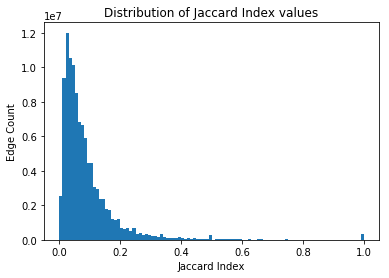

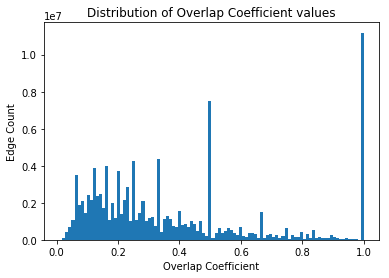

In [16]:
plt.hist(get_linear_weights(jaccard_bp), bins=100)
plt.title("Distribution of Jaccard Index values")
plt.xlabel("Jaccard Index")
plt.ylabel("Edge Count")
plt.show()
plt.hist(get_linear_weights(overlap_bp), bins=100)
plt.title("Distribution of Overlap Coefficient values")
plt.xlabel("Overlap Coefficient")
plt.ylabel("Edge Count")
plt.show()

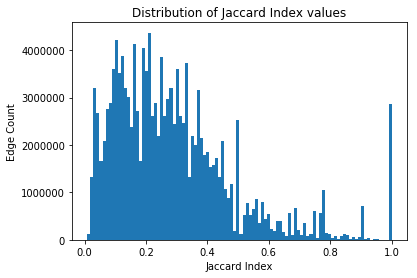

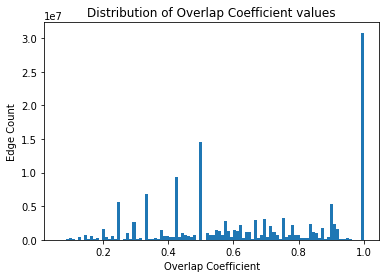

In [17]:
plt.hist(get_linear_weights(jaccard_cc), bins=100)
plt.title("Distribution of Jaccard Index values")
plt.xlabel("Jaccard Index")
plt.ylabel("Edge Count")
plt.show()
plt.hist(get_linear_weights(overlap_cc), bins=100)
plt.title("Distribution of Overlap Coefficient values")
plt.xlabel("Overlap Coefficient")
plt.ylabel("Edge Count")
plt.show()

Since the semantic density can't be calculated with a matrix multiplication, the question is whether my algorithm should try all pair of genes across the genome, or pair all genes within a given go_term iteratively. Conclusion: there are about 5x fewer pairs to consider if I just pair all genes across the genome

In [18]:
#To help estimate the amount of time for generate_semantic_density ...
genes = set()
go_term_pairs = 0
for gene_list in bp_terms.itervalues():
    genes |= set(gene_list)
    go_term_pairs += len(gene_list)**2
print "All genes x All genes", len(genes)**2, "Annotated genes x Annotated genes", go_term_pairs

All genes x All genes 215355625 Annotated genes x Annotated genes 1363518888


### Semantic Density

In [8]:
#Note: before calling generate_semantic_density, filter the go_terms so that
#only genes from the Dab of interest are included
def generate_semantic_density(go_terms):
    # Get the count of all genes in go_terms
    genes = set()
    for gene_list in go_terms.itervalues():
        genes |= set(gene_list)
    genes = list(genes)  
    n = len(genes)
    terms = go_terms.keys()
    
    gene_to_idx = {g: i for i, g in enumerate(genes)}
    
    gene_to_term_matrix = np.zeros((len(genes), len(terms)), dtype=np.float64)
    gene_to_term_idx = {g:[] for g in genes}
    for i, t in enumerate(terms):
        score = -np.log10(len(go_terms[t])/float(n))
        for g in go_terms[t]:
            gene_to_term_matrix[gene_to_idx[g], i] = score
            gene_to_term_idx[g].append(i)
    
    numerator = np.zeros((n,n))
    # For each gene in the genome, calculate the scores connecting to it
    for i in range(n):
        term_idxs = gene_to_term_idx[genes[i]]
        if all(len(go_terms[terms[i]]) == n for i in term_idxs):
            continue
        numerator[i,i:] = gene_to_term_matrix[i:, term_idxs].max(axis=1)
    # Fill in the transpose side
    for i in range(n):
        numerator[i:,i] = numerator[i,i:]
    
    # The self scores for each term are just the scores along the diagonal
    self_scores = numerator[range(n), range(n)]
    denominator = np.add(self_scores.reshape((n, 1)),
                         self_scores.reshape((1, n)))
    
    ret = Dab()
    ret.genes = genes
    ret.weights = np.where(denominator > 0, numerator * 2 / denominator, 0)
    return ret

In [9]:
bp_ngenes = len(bp_annotations)
def check_semantic_density(a, b, ngenes, go_terms):
    intersect = set(set(a) & set(b))
    i_score = max(-np.log10(len(go_terms[t])/float(ngenes)) for t in intersect)
    a_score = max(-np.log10(len(go_terms[t])/float(ngenes)) for t in a)
    b_score = max(-np.log10(len(go_terms[t])/float(ngenes)) for t in b)
    if a_score + b_score == 0:
        return 0
    return i_score*2/(a_score+b_score)

In [10]:
%%time
semantic_bp = generate_semantic_density(bp_terms)

/r04/bparks/2017/venv/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in divide


CPU times: user 1min 23s, sys: 3.19 s, total: 1min 27s
Wall time: 1min 27s


In [11]:
%%time
semantic_cc = generate_semantic_density(cc_terms)

/r04/bparks/2017/venv/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in divide


CPU times: user 27.9 s, sys: 3.38 s, total: 31.2 s
Wall time: 31.2 s


In [21]:
print "Testing Density BP"
test_deviation(semantic_bp, bp_annotations, check_semantic_density, 
               ngenes=len(bp_annotations), go_terms=bp_terms)
print "Testing Density CC"
test_deviation(semantic_cc, cc_annotations, check_semantic_density,
               ngenes=len(cc_annotations), go_terms=cc_terms)

Testing Density BP
Average deviation: 0.0 	Max deviation: 0.0
Testing Density CC
Average deviation: 0.0 	Max deviation: 0.0


Semantic Density with BP terms


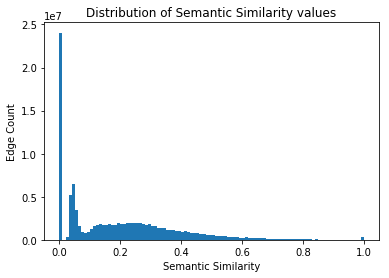

Semantic Density with CC terms


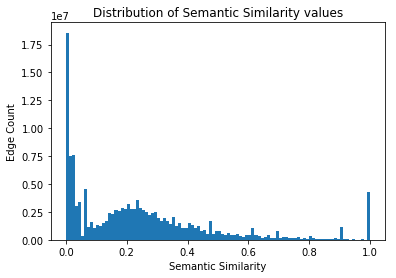

In [13]:
print "Semantic Density with BP terms"
plt.hist(get_linear_weights(semantic_bp), bins=100)
plt.title("Distribution of Semantic Similarity values")
plt.xlabel("Semantic Similarity")
plt.ylabel("Edge Count")
plt.show()
print "Semantic Density with CC terms"
plt.hist(get_linear_weights(semantic_cc), bins=100)
plt.title("Distribution of Semantic Similarity values")
plt.xlabel("Semantic Similarity")
plt.ylabel("Edge Count")
plt.show()

## Correlation of Network Weights with GO values

In [75]:
from matplotlib.colors import LogNorm
def compare_weights(dab, go_similarity, xlab="Network Weights", ylab="GO Weights", cutoff=None):
    # First, we'll just compare genes that are both in gene ontology and the Dab
    genes = list(set(dab.genes) & set(go_similarity.genes))
    print "Subsetting Networks"
    dab_weights = get_linear_weights(dab.subset_genes(genes))
    go_weights = get_linear_weights(go_similarity.subset_genes(genes))
    if cutoff is not None:
        go_weights = go_weights[dab_weights > cutoff]
        dab_weights = dab_weights[dab_weights > cutoff]
        
    print "Beginning Hexbin"
    #plt.hexbin(dab_weights, go_weights, mincnt=1, norm=LogNorm(), gridsize=50)
    plt.hist2d(dab_weights, go_weights, cmin=1, norm=LogNorm(), bins=50)
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.colorbar()
    plt.show()

Plots to see the relationship between network weight and GO similarity. It's really pretty hard to see anything in here, since the network is quite heavily skewed towards low-weight terms

Subsetting Networks
Beginning Hexbin


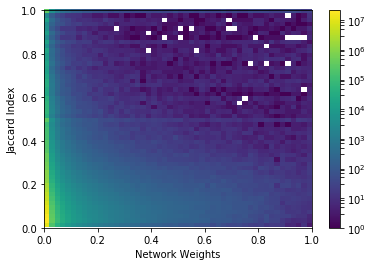

CPU times: user 24.6 s, sys: 4.46 s, total: 29.1 s
Wall time: 28.6 s


In [41]:
%%time
compare_weights(d, jaccard_bp, xlab="Network Weights", ylab="Jaccard Index")

Subsetting Networks
Beginning Hexbin


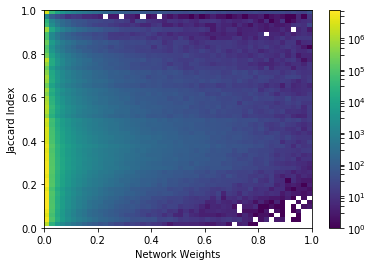

CPU times: user 33.7 s, sys: 5.77 s, total: 39.5 s
Wall time: 38.9 s


In [42]:
%%time
compare_weights(d, jaccard_cc, xlab="Network Weights", ylab="Jaccard Index")

Subsetting Networks
Beginning Hexbin


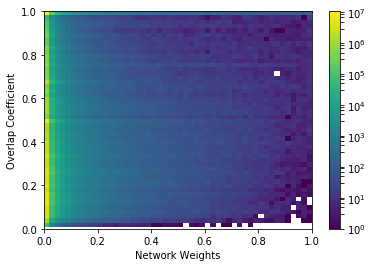

CPU times: user 25.8 s, sys: 4.57 s, total: 30.4 s
Wall time: 29.8 s


In [44]:
%%time
compare_weights(d, overlap_bp, xlab="Network Weights", ylab="Overlap Coefficient")

Subsetting Networks
Beginning Hexbin


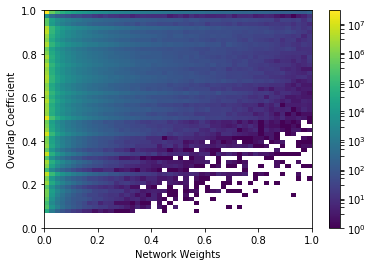

In [45]:
compare_weights(d, overlap_cc, xlab="Network Weights", ylab="Overlap Coefficient")

Subsetting Networks
Beginning Hexbin


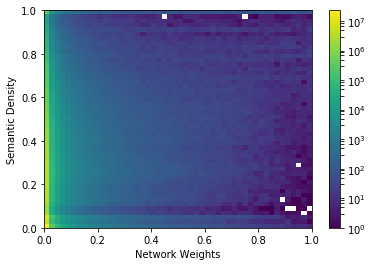

In [46]:
compare_weights(d, semantic_bp, xlab="Network Weights", ylab="Semantic Density")

Subsetting Networks
Beginning Hexbin


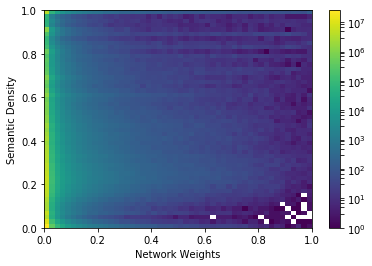

In [47]:
compare_weights(d, semantic_cc, xlab="Network Weights", ylab="Semantic Density")

Maybe the correlation of weights and density will say something useful?

It looks like a very weak correlation, although a correlation nonetheless

In [ ]:
go_weights = [jaccard_bp, jaccard_cc, overlap_bp, overlap_cc, semantic_bp, semantic_cc]
names = ["Jaccard Index (BP)", "Jaccard Index (CC)",
         "Overlap Coefficient (BP)", "Overlap Coefficient (CC)",
         "Semantic Density (BP)", "Semantic Density (CC)"]
results = []
for go_weight, name in zip(go_weights, names):
    genes = list(set(d.genes) & set(go_weight.genes))
    dab_weights = get_linear_weights(d.subset_genes(genes))
    go_weights = get_linear_weights(go_weight.subset_genes(genes))
    pearson, pearson_p = scipy.stats.pearsonr(dab_weights, go_weights)
    spearman, spearman_p = scipy.stats.spearmanr(dab_weights, go_weights)
    results.append({
        'Similarity Measure': name,
        '# of genes': len(genes),
        'Pearson': pearson,
        'Pearson p-val': pearson_p,
        'Spearman': spearman,
        'Spearman p-val': spearman_p
    })
dab_correlation = pd.DataFrame(results)

In [52]:
dab_correlation

# of genes   Pearson  Pearson p-val        Similarity Measure  Spearman  \
0       14611  0.048906            0.0        Jaccard Index (BP)  0.014311   
1       16692  0.043424            0.0        Jaccard Index (CC)  0.031893   
2       14611  0.033922            0.0  Overlap Coefficient (BP)  0.104690   
3       16692  0.033164            0.0  Overlap Coefficient (CC)  0.046068   
4       14611  0.059039            0.0     Semantic Density (BP) -0.028368   
5       16692  0.045517            0.0     Semantic Density (CC)  0.027748   

   Spearman p-val  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
5             0.0

Try a version of the same experiment but with network weights below 0.1 removed

In [77]:
%%time
go_weights = [jaccard_bp, jaccard_cc, overlap_bp, overlap_cc, semantic_bp, semantic_cc]
names = ["Jaccard Index (BP)", "Jaccard Index (CC)",
         "Overlap Coefficient (BP)", "Overlap Coefficient (CC)",
         "Semantic Density (BP)", "Semantic Density (CC)"]
results = []
for go_weight, name in zip(go_weights, names):
    genes = list(set(d.genes) & set(go_weight.genes))
    dab_weights = get_linear_weights(d.subset_genes(genes))
    go_weights = get_linear_weights(go_weight.subset_genes(genes))
    dab_weights_filt = dab_weights[dab_weights > 0.1]
    go_weights_filt = go_weights[dab_weights > 0.1]
    pearson, pearson_p = scipy.stats.pearsonr(dab_weights_filt, go_weights_filt)
    spearman, spearman_p = scipy.stats.spearmanr(dab_weights_filt, go_weights_filt)
    results.append({
        'Similarity Measure': name,
        '# of genes': len(genes),
        'Pearson': pearson,
        'Pearson p-val': pearson_p,
        'Spearman': spearman,
        'Spearman p-val': spearman_p
    })
dab_correlation = pd.DataFrame(results)

CPU times: user 1min 1s, sys: 12.9 s, total: 1min 14s
Wall time: 1min 14s


In [54]:
dab_correlation

# of genes   Pearson  Pearson p-val        Similarity Measure  Spearman  \
0       14611  0.223915            0.0        Jaccard Index (BP)  0.130004   
1       16692  0.165590            0.0        Jaccard Index (CC)  0.139012   
2       14611  0.139564            0.0  Overlap Coefficient (BP)  0.095260   
3       16692  0.116463            0.0  Overlap Coefficient (CC)  0.092179   
4       14611  0.225817            0.0     Semantic Density (BP)  0.151243   
5       16692  0.170746            0.0     Semantic Density (CC)  0.125554   

   Spearman p-val  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
5             0.0

Now trying with a KNN(50) transform to see if that makes the results any better

In [22]:
%%time
knn_dab = KNN(50).transform(d)

CPU times: user 37.8 s, sys: 1.86 s, total: 39.7 s
Wall time: 39.6 s


Subsetting Networks
Beginning Hexbin


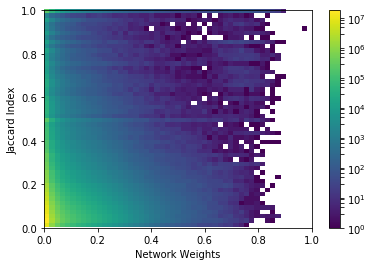

Subsetting Networks
Beginning Hexbin


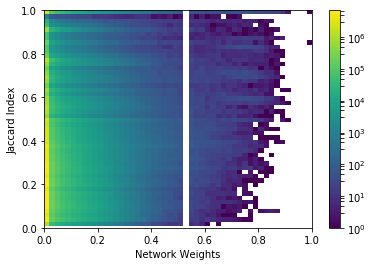

Subsetting Networks
Beginning Hexbin


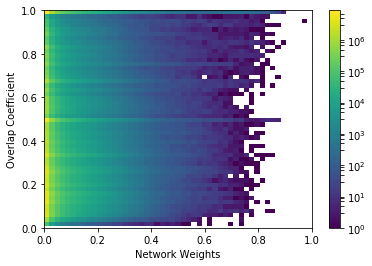

Subsetting Networks
Beginning Hexbin


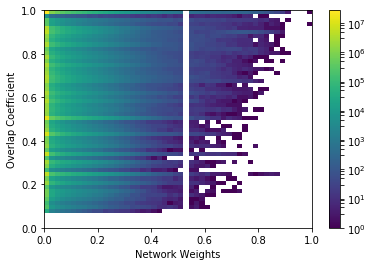

Subsetting Networks
Beginning Hexbin


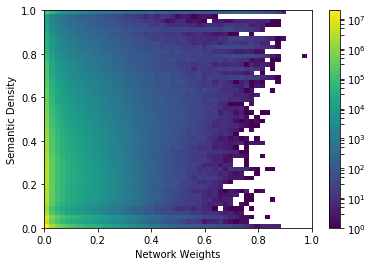

Subsetting Networks
Beginning Hexbin


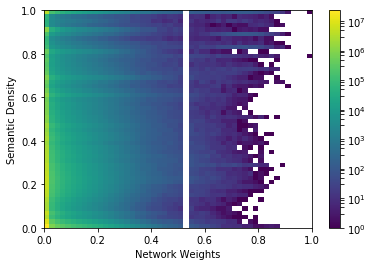

In [74]:
compare_weights(knn_dab, jaccard_bp, xlab="Network Weights", ylab="Jaccard Index")

compare_weights(knn_dab, jaccard_cc, xlab="Network Weights", ylab="Jaccard Index")

compare_weights(knn_dab, overlap_bp, xlab="Network Weights", ylab="Overlap Coefficient")

compare_weights(knn_dab, overlap_cc, xlab="Network Weights", ylab="Overlap Coefficient")

compare_weights(knn_dab, semantic_bp, xlab="Network Weights", ylab="Semantic Density")

compare_weights(knn_dab, semantic_cc, xlab="Network Weights", ylab="Semantic Density")

In [68]:
%%time
go_weights = [jaccard_bp, jaccard_cc, overlap_bp, overlap_cc, semantic_bp, semantic_cc]
names = ["Jaccard Index (BP)", "Jaccard Index (CC)",
         "Overlap Coefficient (BP)", "Overlap Coefficient (CC)",
         "Semantic Density (BP)", "Semantic Density (CC)"]
results_knn = []
for go_weight, name in zip(go_weights, names):
    genes = set(knn_dab.genes) & set(go_weight.genes)
    dab_weights = get_linear_weights(knn_dab.subset_genes(genes))
    go_weights = get_linear_weights(go_weight.subset_genes(genes))
    dab_weights_filt = dab_weights[dab_weights > 0.1]
    go_weights_filt = go_weights[dab_weights > 0.1]
    pearson, pearson_p = scipy.stats.pearsonr(dab_weights_filt, go_weights_filt)
    spearman, spearman_p = scipy.stats.spearmanr(dab_weights_filt, go_weights_filt)
    results_knn.append({
        'Similarity Measure': name,
        '# of genes': len(genes),
        'Pearson': pearson,
        'Pearson p-val': pearson_p,
        'Spearman': spearman,
        'Spearman p-val': spearman_p
    })
dab_correlation_knn = pd.DataFrame(results_knn)

CPU times: user 1min 9s, sys: 13.8 s, total: 1min 23s
Wall time: 1min 23s


In [69]:
dab_correlation_knn

# of genes   Pearson  Pearson p-val        Similarity Measure  Spearman  \
0       14611  0.136854            0.0        Jaccard Index (BP)  0.054846   
1       16692  0.086040            0.0        Jaccard Index (CC)  0.038281   
2       14611  0.066847            0.0  Overlap Coefficient (BP)  0.033378   
3       16692  0.052454            0.0  Overlap Coefficient (CC)  0.023677   
4       14611  0.128819            0.0     Semantic Density (BP)  0.051399   
5       16692  0.091943            0.0     Semantic Density (CC)  0.043551   

   Spearman p-val  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
5             0.0

In [23]:
def correlation_with_cutoff(dab, go_weight, name, percentile=90):
    genes = set(dab.genes) & set(go_weight.genes)
    dab_weights = get_linear_weights(dab.subset_genes(genes))
    go_weights = get_linear_weights(go_weight.subset_genes(genes))
    cutoff = np.percentile(dab_weights, percentile)
    dab_weights_filt = dab_weights[dab_weights >= cutoff]
    go_weights_filt = go_weights[dab_weights >= cutoff]
    pearson, pearson_p = scipy.stats.pearsonr(dab_weights_filt, go_weights_filt)
    spearman, spearman_p = scipy.stats.spearmanr(dab_weights_filt, go_weights_filt)
    return {
        'Similarity Measure': name,
        '# of genes': len(genes),
        'Pearson': pearson,
        'Pearson p-val': pearson_p,
        'Spearman': spearman,
        'Spearman p-val': spearman_p
    }

In [121]:
%%time
go_weights = [jaccard_bp, jaccard_cc, overlap_bp, overlap_cc, semantic_bp, semantic_cc]
names = ["Jaccard Index (BP)", "Jaccard Index (CC)",
         "Overlap Coefficient (BP)", "Overlap Coefficient (CC)",
         "Semantic Density (BP)", "Semantic Density (CC)"]
percentile_correlation_results = []
for go_weight, name in zip(go_weights, names):
    res1 = correlation_with_cutoff(d, go_weight, name)
    res2 = correlation_with_cutoff(knn_dab, go_weight, name)
    res1['Transform'] = 'None'
    res2['Transform'] = 'KNN(50)'
    percentile_correlation_results.append(res1)
    percentile_correlation_results.append(res2)
percentile_correlation = pd.DataFrame(percentile_correlation_results)

CPU times: user 4min 22s, sys: 43.5 s, total: 5min 5s
Wall time: 5min 5s


In [122]:
percentile_correlation

# of genes   Pearson  Pearson p-val        Similarity Measure  Spearman  \
0        14611  0.084395   0.000000e+00        Jaccard Index (BP)  0.080300   
1        14611  0.047934   0.000000e+00        Jaccard Index (BP)  0.043605   
2        16692  0.074488   0.000000e+00        Jaccard Index (CC)  0.084793   
3        16692  0.016507   0.000000e+00        Jaccard Index (CC)  0.002819   
4        14611  0.026123   0.000000e+00  Overlap Coefficient (BP)  0.005598   
5        14611  0.009039   0.000000e+00  Overlap Coefficient (BP)  0.003019   
6        16692  0.055658   0.000000e+00  Overlap Coefficient (CC)  0.037455   
7        16692 -0.002205   8.236415e-30  Overlap Coefficient (CC) -0.007057   
8        14611  0.117502   0.000000e+00     Semantic Density (BP)  0.140571   
9        14611  0.077241   0.000000e+00     Semantic Density (BP)  0.063129   
10       16692  0.074083   0.000000e+00     Semantic Density (CC)  0.100632   
11       16692  0.038265   0.000000e+00     Semantic Density (CC)  0.021439   

    Spearman p-val Transform  
0     0.000000e+00      None  
1     0.000000e+00   KNN(50)  
2     0.000000e+00      None  
3     1.198387e-47   KNN(50)  
4     1.030738e-74      None  
5     5.085964e-43   KNN(50)  
6     0.000000e+00      None  
7    1.380972e-288   KNN(50)  
8     0.000000e+00      None  
9     0.000000e+00   KNN(50)  
10    0.000000e+00      None  
11    0.000000e+00   KNN(50)

In [51]:
#Same as correlation with cutoff but requires being > cutoff, not just >=
def correlation_with_cutoff_strict(dab, go_weight, name, percentile=90):
    genes = set(dab.genes) & set(go_weight.genes)
    dab_weights = get_linear_weights(dab.subset_genes(genes))
    go_weights = get_linear_weights(go_weight.subset_genes(genes))
    cutoff = np.percentile(dab_weights, percentile)
    dab_weights_filt = dab_weights[dab_weights > cutoff]
    go_weights_filt = go_weights[dab_weights > cutoff]
    pearson, pearson_p = scipy.stats.pearsonr(dab_weights_filt, go_weights_filt)
    spearman, spearman_p = scipy.stats.spearmanr(dab_weights_filt, go_weights_filt)
    return {
        'Similarity Measure': name,
        '# of genes': len(genes),
        'Pearson': pearson,
        'Pearson p-val': pearson_p,
        'Spearman': spearman,
        'Spearman p-val': spearman_p
    }

In [52]:
%%time
go_weights = [jaccard_bp, jaccard_cc, overlap_bp, overlap_cc, semantic_bp, semantic_cc]
names = ["Jaccard Index (BP)", "Jaccard Index (CC)",
         "Overlap Coefficient (BP)", "Overlap Coefficient (CC)",
         "Semantic Density (BP)", "Semantic Density (CC)"]
percentile_5_correlation_results = []
for go_weight, name in zip(go_weights, names):
    res1 = correlation_with_cutoff_strict(d, go_weight, name, percentile=5)
    res2 = correlation_with_cutoff_strict(knn_dab, go_weight, name, percentile=5)
    res1['Transform'] = 'None'
    res2['Transform'] = 'KNN(50)'
    percentile_5_correlation_results.append(res1)
    percentile_5_correlation_results.append(res2)
percentile_5_correlation = pd.DataFrame(percentile_5_correlation_results)

CPU times: user 13min 28s, sys: 1min 39s, total: 15min 7s
Wall time: 15min 7s


In [53]:
percentile_5_correlation

# of genes   Pearson  Pearson p-val        Similarity Measure  Spearman  \
0        14611  0.048095   0.000000e+00        Jaccard Index (BP)  0.012905   
1        14611  0.047934   0.000000e+00        Jaccard Index (BP)  0.043605   
2        16692  0.041046   0.000000e+00        Jaccard Index (CC)  0.021494   
3        16692  0.016507   0.000000e+00        Jaccard Index (CC)  0.002819   
4        14611  0.031061   0.000000e+00  Overlap Coefficient (BP)  0.099042   
5        14611  0.009039   0.000000e+00  Overlap Coefficient (BP)  0.003019   
6        16692  0.030125   0.000000e+00  Overlap Coefficient (CC)  0.032812   
7        16692 -0.002205   8.236415e-30  Overlap Coefficient (CC) -0.007057   
8        14611  0.060996   0.000000e+00     Semantic Density (BP) -0.024922   
9        14611  0.077241   0.000000e+00     Semantic Density (BP)  0.063129   
10       16692  0.043759   0.000000e+00     Semantic Density (CC)  0.020922   
11       16692  0.038265   0.000000e+00     Semantic Density (CC)  0.021439   

    Spearman p-val Transform  
0     0.000000e+00      None  
1     0.000000e+00   KNN(50)  
2     0.000000e+00      None  
3     1.198387e-47   KNN(50)  
4     0.000000e+00      None  
5     5.085964e-43   KNN(50)  
6     0.000000e+00      None  
7    1.380972e-288   KNN(50)  
8     0.000000e+00      None  
9     0.000000e+00   KNN(50)  
10    0.000000e+00      None  
11    0.000000e+00   KNN(50)

Do we get a clearer signal by binning the network weights then inspecting the distribution of GO similarity? (This is basically equivalent to dividing the 2d histogram bins by the number of samples in the column)

In [24]:
def get_binned_weights(dab, go_similarity, bins=100):
    # First, we'll just compare genes that are both in gene ontology and the Dab
    print "Subsetting Networks"
    genes = list(set(dab.genes) & set(go_similarity.genes))
    dab_weights = get_linear_weights(dab.subset_genes(genes))
    go_weights = get_linear_weights(go_similarity.subset_genes(genes))
    print "Sorting Edges"
    sorted_order = dab_weights.argsort()
    dab_weights = dab_weights[sorted_order]
    go_weights = go_weights[sorted_order]
    
    print "Finding Partitions"
    weight_min, weight_max = min(0.0,dab_weights.min()), max(1.0,dab_weights.max())
    mean_go_weight = []
    median_go_weight = []
    go_weight_25 = []
    go_weight_75 = []
    x = []
    for i in range(bins):
        bin_min = i * float(weight_max - weight_min)/bins
        bin_max = (i+1) * float(weight_max - weight_min)/bins
        # Make the last bin inclusive on the right by raising the max
        if i+1 == bins:
            bin_max += 1
        idx_min, idx_max = np.searchsorted(dab_weights, [bin_min, bin_max])
        if idx_min == idx_max:
            continue
        go_weights_filt = go_weights[idx_min:idx_max]
        mean_go_weight.append(go_weights_filt.mean())
        p25, p75 = np.percentile(go_weights_filt, [25,75])
        go_weight_25.append(p25)
        go_weight_75.append(p75)
        median_go_weight.append(np.median(go_weights_filt))
        x.append(i * (weight_max-weight_min)/bins)
    return x, mean_go_weight, median_go_weight, go_weight_25, go_weight_75

In [25]:
def plot_binned_weights(dab, go_similarity, bins=100, xlab="Network Weight", ylab="GO Similarity"):
    x, mean_go_weight, median_go_weight, go_weight_25, go_weight_75 = get_binned_weights(dab, go_similarity, bins=bins)
    yerr = [np.subtract(median_go_weight, go_weight_25), 
            np.subtract(go_weight_75, median_go_weight)]
    plt.errorbar(x, median_go_weight, yerr=yerr)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()


Subsetting Networks
Sorting Edges
Finding Partitions


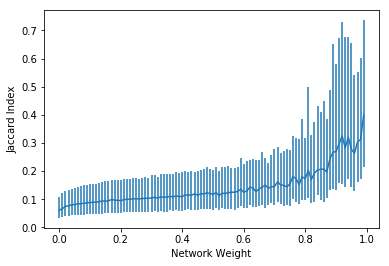

Subsetting Networks
Sorting Edges
Finding Partitions


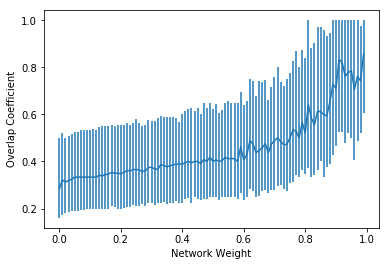

Subsetting Networks
Sorting Edges
Finding Partitions


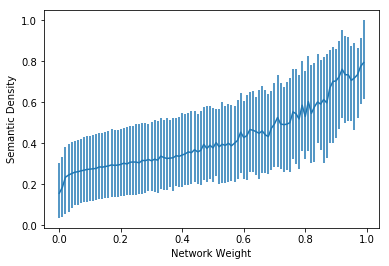

In [115]:
plot_binned_weights(d, jaccard_bp, ylab="Jaccard Index")
plot_binned_weights(d, overlap_bp, ylab="Overlap Coefficient")
plot_binned_weights(d, semantic_bp, ylab="Semantic Density")

Subsetting Networks
Sorting Edges
Finding Partitions


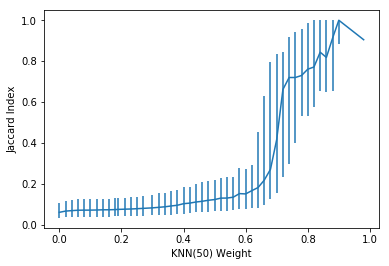

Subsetting Networks
Sorting Edges
Finding Partitions


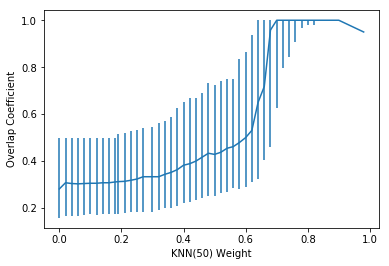

Subsetting Networks
Sorting Edges
Finding Partitions


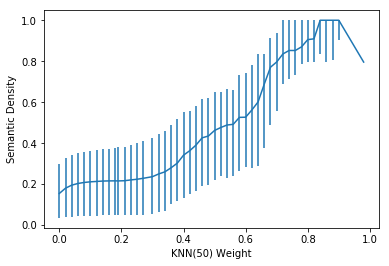

In [116]:
plot_binned_weights(knn_dab, jaccard_bp, ylab="Jaccard Index", xlab="KNN(50) Weight")
plot_binned_weights(knn_dab, overlap_bp, ylab="Overlap Coefficient", xlab="KNN(50) Weight")
plot_binned_weights(knn_dab, semantic_bp, ylab="Semantic Density", xlab="KNN(50) Weight")

### Viewing percentile overlap
As a final attempt at getting a reasonable metric, I'll look at the number of edges that overlap between the top x% of GO Similarity and the top x% of Network Weights

In [39]:
def get_percentile_overlap(dab, go_similarity, percentile_cutoff=90):
    genes = list(set(dab.genes) & set(go_similarity.genes))
    dab_weights = get_linear_weights(dab.subset_genes(genes))
    go_weights = get_linear_weights(go_similarity.subset_genes(genes))
    dab_cutoff = np.percentile(dab_weights, percentile_cutoff)
    go_cutoff = np.percentile(go_weights, percentile_cutoff)
    top_dab_weights = dab_weights >= dab_cutoff
    top_go_weights = go_weights >= go_cutoff
    assert len(dab_weights) == len(go_weights)
    return {
        'Total Edges': len(dab_weights),
        'Network Edge Count': top_dab_weights.sum(),
        'Similarity Edge Count': top_go_weights.sum(),
        'Overlapping Edge Count': np.logical_and(top_dab_weights, top_go_weights).sum()
    }

In [40]:
%%time
go_weights = [jaccard_bp, jaccard_cc, overlap_bp, overlap_cc, semantic_bp, semantic_cc]
names = ["Jaccard Index (BP)", "Jaccard Index (CC)",
         "Overlap Coefficient (BP)", "Overlap Coefficient (CC)",
         "Semantic Density (BP)", "Semantic Density (CC)"]
percentile_overlap_results = []
for go_weight, name in zip(go_weights, names):
    res1 = get_percentile_overlap(d, go_weight)
    res2 = get_percentile_overlap(knn_dab, go_weight)
    res1['Transform'] = 'None'
    res2['Transform'] = 'KNN(50)'
    res1['Similarity Measure'] = name
    res2['Similarity Measure'] = name
    percentile_overlap_results.append(res1)
    percentile_overlap_results.append(res2)
percentile_overlap = pd.DataFrame(percentile_overlap_results)

CPU times: user 2min 39s, sys: 35 s, total: 3min 14s
Wall time: 3min 14s


In [41]:
percentile_overlap

Network Edge Count  Overlapping Edge Count  Similarity Edge Count  \
0             10673491                 1433914               10683983   
1             20741313                 2563256               10683983   
2             13930357                 1711280               13956319   
3             26461818                 3131520               13956319   
4             10673491                 1022208               11025952   
5             20741313                 2109280               11025952   
6             13930357                 3247473               30397707   
7             26461818                 6283405               30397707   
8             10673491                 1629303               10673743   
9             20741313                 2785232               10673743   
10            13930357                 1785454               13930335   
11            26461818                 3334327               13930335   

          Similarity Measure  Total Edges Transform  
0         Jaccard Index (BP)    106733355      None  
1         Jaccard Index (BP)    106733355   KNN(50)  
2         Jaccard Index (CC)    139303086      None  
3         Jaccard Index (CC)    139303086   KNN(50)  
4   Overlap Coefficient (BP)    106733355      None  
5   Overlap Coefficient (BP)    106733355   KNN(50)  
6   Overlap Coefficient (CC)    139303086      None  
7   Overlap Coefficient (CC)    139303086   KNN(50)  
8      Semantic Density (BP)    106733355      None  
9      Semantic Density (BP)    106733355   KNN(50)  
10     Semantic Density (CC)    139303086      None  
11     Semantic Density (CC)    139303086   KNN(50)

In [42]:
f = pd.DataFrame(percentile_overlap)
background_rate = f['Similarity Edge Count']/f['Total Edges']
enriched_rate = f['Overlapping Edge Count']/f['Network Edge Count']
f['Fold Enrichment'] = enriched_rate/background_rate
f

Network Edge Count  Overlapping Edge Count  Similarity Edge Count  \
0             10673491                 1433914               10683983   
1             20741313                 2563256               10683983   
2             13930357                 1711280               13956319   
3             26461818                 3131520               13956319   
4             10673491                 1022208               11025952   
5             20741313                 2109280               11025952   
6             13930357                 3247473               30397707   
7             26461818                 6283405               30397707   
8             10673491                 1629303               10673743   
9             20741313                 2785232               10673743   
10            13930357                 1785454               13930335   
11            26461818                 3334327               13930335   

          Similarity Measure  Total Edges Transform  Fold Enrichment  
0         Jaccard Index (BP)    106733355      None         1.342096  
1         Jaccard Index (BP)    106733355   KNN(50)         1.234590  
2         Jaccard Index (CC)    139303086      None         1.226164  
3         Jaccard Index (CC)    139303086   KNN(50)         1.181205  
4   Overlap Coefficient (BP)    106733355      None         0.927079  
5   Overlap Coefficient (BP)    106733355   KNN(50)         0.984424  
6   Overlap Coefficient (CC)    139303086      None         1.068325  
7   Overlap Coefficient (CC)    139303086   KNN(50)         1.088166  
8      Semantic Density (BP)    106733355      None         1.526437  
9      Semantic Density (BP)    106733355   KNN(50)         1.342791  
10     Semantic Density (CC)    139303086      None         1.281698  
11     Semantic Density (CC)    139303086   KNN(50)         1.260050

In [46]:
%%time
f['p-val'] = scipy.stats.hypergeom.sf(f['Overlapping Edge Count'], f['Total Edges'], f['Similarity Edge Count'], f['Network Edge Count'])

CPU times: user 1min 14s, sys: 5.76 s, total: 1min 19s
Wall time: 1min 20s


In [47]:
f

Network Edge Count  Overlapping Edge Count  Similarity Edge Count  \
0             10673491                 1433914               10683983   
1             20741313                 2563256               10683983   
2             13930357                 1711280               13956319   
3             26461818                 3131520               13956319   
4             10673491                 1022208               11025952   
5             20741313                 2109280               11025952   
6             13930357                 3247473               30397707   
7             26461818                 6283405               30397707   
8             10673491                 1629303               10673743   
9             20741313                 2785232               10673743   
10            13930357                 1785454               13930335   
11            26461818                 3334327               13930335   

          Similarity Measure  Total Edges Transform  Fold Enrichment  p-val  
0         Jaccard Index (BP)    106733355      None         1.342096    0.0  
1         Jaccard Index (BP)    106733355   KNN(50)         1.234590    0.0  
2         Jaccard Index (CC)    139303086      None         1.226164    0.0  
3         Jaccard Index (CC)    139303086   KNN(50)         1.181205    0.0  
4   Overlap Coefficient (BP)    106733355      None         0.927079    1.0  
5   Overlap Coefficient (BP)    106733355   KNN(50)         0.984424    1.0  
6   Overlap Coefficient (CC)    139303086      None         1.068325    0.0  
7   Overlap Coefficient (CC)    139303086   KNN(50)         1.088166    0.0  
8      Semantic Density (BP)    106733355      None         1.526437    0.0  
9      Semantic Density (BP)    106733355   KNN(50)         1.342791    0.0  
10     Semantic Density (CC)    139303086      None         1.281698    0.0  
11     Semantic Density (CC)    139303086   KNN(50)         1.260050    0.0

Try again but with the top 25% of edges kept

In [55]:
%%time
go_weights = [jaccard_bp, jaccard_cc, overlap_bp, overlap_cc, semantic_bp, semantic_cc]
names = ["Jaccard Index (BP)", "Jaccard Index (CC)",
         "Overlap Coefficient (BP)", "Overlap Coefficient (CC)",
         "Semantic Density (BP)", "Semantic Density (CC)"]
percentile_overlap_results2 = []
for go_weight, name in zip(go_weights, names):
    res1 = get_percentile_overlap(d, go_weight, percentile_cutoff=75)
    res2 = get_percentile_overlap(knn_dab, go_weight, percentile_cutoff=75)
    res1['Transform'] = 'None'
    res2['Transform'] = 'KNN(50)'
    res1['Similarity Measure'] = name
    res2['Similarity Measure'] = name
    percentile_overlap_results2.append(res1)
    percentile_overlap_results2.append(res2)
percentile_overlap2 = pd.DataFrame(percentile_overlap_results2)

CPU times: user 2min 46s, sys: 28.5 s, total: 3min 15s
Wall time: 3min 15s


In [56]:
percentile_overlap2

Network Edge Count  Overlapping Edge Count  Similarity Edge Count  \
0             26683347                 7263102               26973923   
1            106733355                26973923               26973923   
2             34825773                 9429961               34843778   
3            139303086                34843778               34843778   
4             26683347                10126096               31136239   
5            106733355                31136239               31136239   
6             34825773                 9552218               35159510   
7            139303086                35159510               35159510   
8             26683347                 6903005               26683398   
9            106733355                26683398               26683398   
10            34825773                 9836635               34839518   
11           139303086                34839518               34839518   

          Similarity Measure  Total Edges Transform  
0         Jaccard Index (BP)    106733355      None  
1         Jaccard Index (BP)    106733355   KNN(50)  
2         Jaccard Index (CC)    139303086      None  
3         Jaccard Index (CC)    139303086   KNN(50)  
4   Overlap Coefficient (BP)    106733355      None  
5   Overlap Coefficient (BP)    106733355   KNN(50)  
6   Overlap Coefficient (CC)    139303086      None  
7   Overlap Coefficient (CC)    139303086   KNN(50)  
8      Semantic Density (BP)    106733355      None  
9      Semantic Density (BP)    106733355   KNN(50)  
10     Semantic Density (CC)    139303086      None  
11     Semantic Density (CC)    139303086   KNN(50)

In [58]:
f = pd.DataFrame(percentile_overlap2)
background_rate = f['Similarity Edge Count']/f['Total Edges']
enriched_rate = f['Overlapping Edge Count']/f['Network Edge Count']
f['Fold Enrichment'] = enriched_rate/background_rate
f

Network Edge Count  Overlapping Edge Count  Similarity Edge Count  \
0             26683347                 7263102               26973923   
1            106733355                26973923               26973923   
2             34825773                 9429961               34843778   
3            139303086                34843778               34843778   
4             26683347                10126096               31136239   
5            106733355                31136239               31136239   
6             34825773                 9552218               35159510   
7            139303086                35159510               35159510   
8             26683347                 6903005               26683398   
9            106733355                26683398               26683398   
10            34825773                 9836635               34839518   
11           139303086                34839518               34839518   

          Similarity Measure  Total Edges Transform  Fold Enrichment  
0         Jaccard Index (BP)    106733355      None         1.077055  
1         Jaccard Index (BP)    106733355   KNN(50)         1.000000  
2         Jaccard Index (CC)    139303086      None         1.082542  
3         Jaccard Index (CC)    139303086   KNN(50)         1.000000  
4   Overlap Coefficient (BP)    106733355      None         1.300876  
5   Overlap Coefficient (BP)    106733355   KNN(50)         1.000000  
6   Overlap Coefficient (CC)    139303086      None         1.086729  
7   Overlap Coefficient (CC)    139303086   KNN(50)         1.000000  
8      Semantic Density (BP)    106733355      None         1.034801  
9      Semantic Density (BP)    106733355   KNN(50)         1.000000  
10     Semantic Density (CC)    139303086      None         1.129365  
11     Semantic Density (CC)    139303086   KNN(50)         1.000000